# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [10]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [19]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [34]:
#for i_step, (x, y) in enumerate(train_loader):
    #prediction = nn_model(x)
    #print(torch.max(prediction, 1))
    #print(x, y)
    #print(prediction)

In [256]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

14651
Average loss: 0.960530, Train accuracy: 0.782548, Val accuracy: 0.762542
14651
Average loss: 0.958923, Train accuracy: 0.781115, Val accuracy: 0.777217
14651
Average loss: 0.955663, Train accuracy: 0.783401, Val accuracy: 0.777285


In [349]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
            prediction = model(x)    
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

    val_accuracy = float(correct_samples) / total_samples
    model.train()
    return(val_accuracy)
    
    raise Exception("Not implemented")
    
    return 0

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

#### Добавьте еще один скрытый слой размера 100 нейронов к модели

In [35]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),    
            nn.Linear(100, 10), 
         )

nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.164719, Train accuracy: 0.203819, Val accuracy: 0.216231
Average loss: 2.023741, Train accuracy: 0.262789, Val accuracy: 0.314245
Average loss: 1.829210, Train accuracy: 0.372061, Val accuracy: 0.399631
Average loss: 1.704466, Train accuracy: 0.426782, Val accuracy: 0.435056
Average loss: 1.672268, Train accuracy: 0.440637, Val accuracy: 0.417241


#### Добавьте слой с Batch Normalization

In [37]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=0.001, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.920018, Train accuracy: 0.386718, Val accuracy: 0.547676
Average loss: 1.483775, Train accuracy: 0.604426, Val accuracy: 0.653334
Average loss: 1.309707, Train accuracy: 0.660257, Val accuracy: 0.668282
Average loss: 1.216997, Train accuracy: 0.686227, Val accuracy: 0.701181
Average loss: 1.160585, Train accuracy: 0.701601, Val accuracy: 0.720770


#### Добавьте уменьшение скорости обучения по ходу тренировки.

In [46]:
from torch.optim.lr_scheduler import StepLR

In [67]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f, Learning rate: %f" % 
              (ave_loss, train_accuracy, val_accuracy, scheduler.get_last_lr()[0]))
        print(f"Learning rate: {scheduler.get_last_lr()}")
        ####################добавлено##################
        scheduler.step()
        ###############################################
    return loss_history, train_history, val_history

In [71]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
         )

# step_size: at how many multiples of epoch you decay
# step_size = 1, after every 1 epoch, new_lr = lr*gamma 
# step_size = 2, after every 2 epoch, new_lr = lr*gamma

optimizer = optim.SGD(nn_model.parameters(), lr=0.001, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 14)

Average loss: 1.908625, Train accuracy: 0.385097, Val accuracy: 0.551771, Learning rate: 0.001000
Learning rate: [0.001]
Average loss: 1.470170, Train accuracy: 0.604648, Val accuracy: 0.644802, Learning rate: 0.001000
Learning rate: [0.001]
Average loss: 1.297153, Train accuracy: 0.662953, Val accuracy: 0.681250, Learning rate: 0.001000
Learning rate: [0.001]
Average loss: 1.203325, Train accuracy: 0.687728, Val accuracy: 0.701113, Learning rate: 0.001000
Learning rate: [0.001]
Average loss: 1.143941, Train accuracy: 0.704723, Val accuracy: 0.689168, Learning rate: 0.001000
Learning rate: [0.001]
Average loss: 1.074572, Train accuracy: 0.729140, Val accuracy: 0.734216, Learning rate: 0.000250
Learning rate: [0.00025]
Average loss: 1.055972, Train accuracy: 0.735897, Val accuracy: 0.732851, Learning rate: 0.000500
Learning rate: [0.0005]
Average loss: 1.039073, Train accuracy: 0.742296, Val accuracy: 0.731076, Learning rate: 0.000500
Learning rate: [0.0005]
Average loss: 1.024207, Trai

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [73]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

In [120]:
import itertools

In [264]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    #val_sampler = SubsetRandomSampler(indices)
    #val_loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=val_sampler)
    
    # За счет использования SubsetSampler вместо SubsetRandomSampler порядок извлечения сэмплов из датасета
    # сохраняется, поэтому данная проверка всегда будет пройдена: gt[100] == data_train[val_indices[100]][1]
    
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=sampler)
    
    ground_truth = []
    predictions = []
    
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)    
        _, indices = torch.max(prediction, 1)
        predictions.append(indices.tolist())
        ground_truth.append(y.tolist())


    model.train()
    
    
    #raise Exception("Not implemented")
    # Сводим в одномерный массив
    predictions = list(itertools.chain.from_iterable(predictions))
    ground_truth = list(itertools.chain.from_iterable(ground_truth))
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

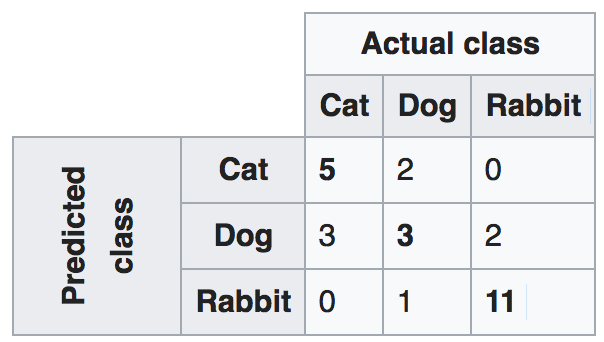

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [258]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')

In [269]:
predictions = np.array(predictions)

In [270]:
gt = np.array(gt)

In [273]:
sum(gt == predictions)

11388

In [274]:
gt == 0

array([False, False, False, ..., False, False, False])

In [276]:
sum(predictions[gt == 0] == 0)

733

In [277]:
sum(predictions[gt == 0] == 1)

100

In [284]:
sum(predictions[gt == 5] == 8)

19

In [278]:
confusion_matrix = np.zeros((10,10), np.int)

In [280]:
confusion_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [281]:
for i in range(10):
    for j in range(10):
        confusion_matrix[i, j] = sum(gt[predictions == i] == j)

In [282]:
confusion_matrix

array([[ 733,   18,    8,   12,    6,   16,   29,   10,   20,   35],
       [ 100, 2498,  118,  146,  121,   57,   70,  130,   87,   90],
       [  25,   51, 1819,   91,   39,   28,   26,  116,   49,   44],
       [  21,   30,   39, 1212,   14,  132,   26,   32,   51,   52],
       [  41,   40,   42,   28, 1244,   23,   63,   11,   45,   25],
       [   7,   14,   14,  116,   20, 1017,   80,    7,   55,   47],
       [  32,    8,   18,   10,   14,   47,  852,    8,   77,   12],
       [  18,   24,   45,   23,    2,    8,   15,  789,    6,   14],
       [  10,    6,   16,   24,    7,   19,   31,    4,  627,   16],
       [  20,    3,   17,   10,   25,   14,    7,    8,   28,  597]])

In [285]:
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for i in range(10):
        for j in range(10):
            confusion_matrix[i, j] = sum(ground_truth[predictions == i] == j)
    # TODO: Implement filling the prediction matrix
    return confusion_matrix

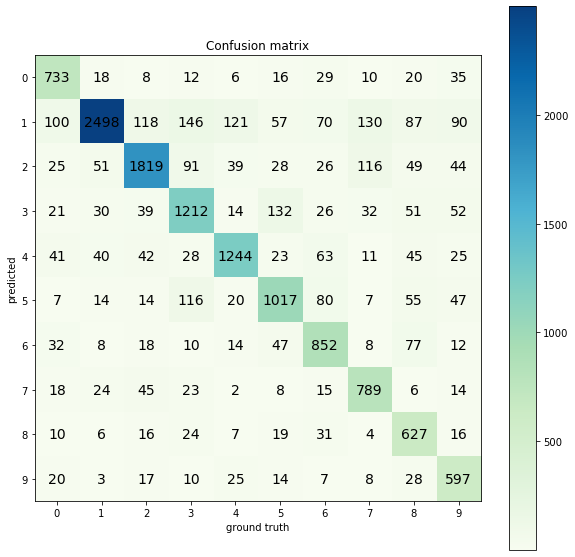

In [286]:
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [324]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)

In [325]:
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    indices = val_indices[(groud_truth == gt_class) & (predictions == predicted_class)]
    visualize_images(indices, data, title='', max_num=10)
    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    #raise Exception("Not implemented")

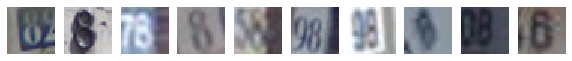

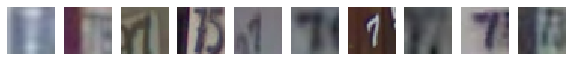

In [326]:
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

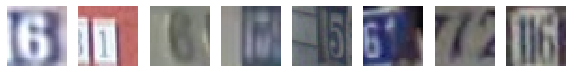

In [335]:
visualize_predicted_actual(6, 1, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [19]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

In [20]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [21]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    train_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    val_loss_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        train_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy, val_loss = compute_accuracy(model, val_loader, loss)
        
        train_loss_history.append(float(train_loss))
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
        val_loss_history.append(float(val_loss))
        print("Train loss: %f, Validate loss: %f, Train accuracy: %f, Val accuracy: %f, Learning rate: %f" % 
              (train_loss, val_loss, train_accuracy, val_accuracy, scheduler.get_last_lr()[0]))
        ####################добавлено##################
        scheduler.step()
        ###############################################
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [22]:
def compute_accuracy(model, loader, loss):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss_value

    val_accuracy = float(correct_samples) / total_samples
    val_loss = loss_accum / (i_step + 1)
    model.train()
    return(val_accuracy, val_loss)
    
    raise Exception("Not implemented")
    
    return 0

In [23]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 300),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(300),
            nn.Linear(300, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
         )

# step_size: at how many multiples of epoch you decay
# step_size = 1, after every 1 epoch, new_lr = lr*gamma 
# step_size = 2, after every 2 epoch, new_lr = lr*gamma

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0001, weight_decay=1e-1, betas=(0.9, 0.999))
#optimizer = optim.SGD(nn_model.parameters(), lr=0.001, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
num_epoch = 14

In [24]:
%%time
train_loss, val_loss, train_accuracy, val_accuracy = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, num_epoch)

Train loss: 1.519628, Validate loss: 1.161159, Train accuracy: 0.539330, Val accuracy: 0.682411, Learning rate: 0.000100
Train loss: 1.062853, Validate loss: 1.013554, Train accuracy: 0.690356, Val accuracy: 0.703024, Learning rate: 0.000100
Train loss: 0.934942, Validate loss: 0.909383, Train accuracy: 0.722281, Val accuracy: 0.730462, Learning rate: 0.000100
Train loss: 0.785727, Validate loss: 0.758551, Train accuracy: 0.773982, Val accuracy: 0.783906, Learning rate: 0.000050
Train loss: 0.743235, Validate loss: 0.746560, Train accuracy: 0.788981, Val accuracy: 0.787182, Learning rate: 0.000050
Train loss: 0.717009, Validate loss: 0.718741, Train accuracy: 0.796062, Val accuracy: 0.802744, Learning rate: 0.000050
Train loss: 0.631694, Validate loss: 0.659967, Train accuracy: 0.827458, Val accuracy: 0.820422, Learning rate: 0.000025
Train loss: 0.610022, Validate loss: 0.635844, Train accuracy: 0.834573, Val accuracy: 0.831479, Learning rate: 0.000025
Train loss: 0.596453, Validate l

In [14]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy, _ = compute_accuracy(nn_model, test_loader, loss)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8265


In [15]:
import matplotlib.pyplot as plt

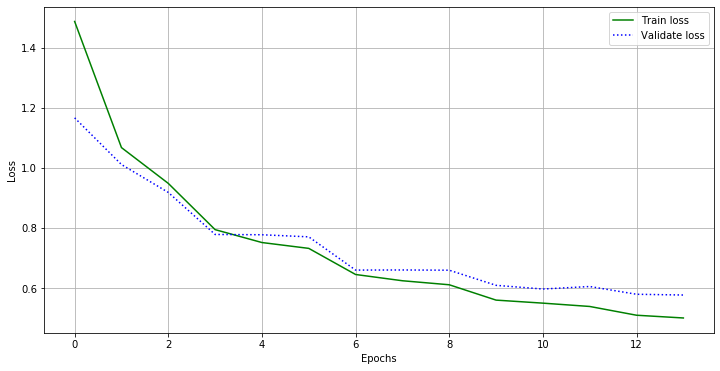

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, '-g', label='Train loss')
plt.plot(val_loss, ':b', label='Validate loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

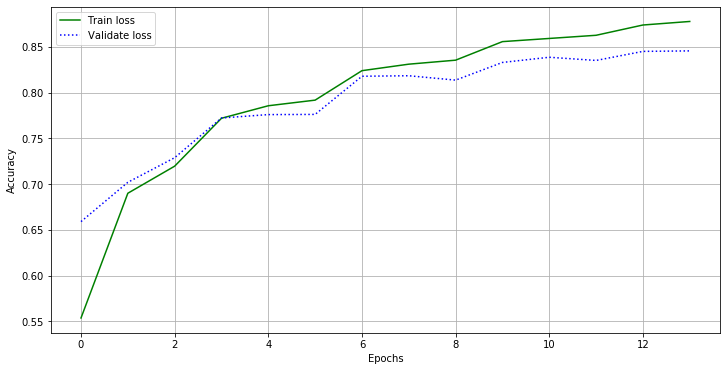

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, '-g', label='Train loss')
plt.plot(val_accuracy, ':b', label='Validate loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend();